In [1]:
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import regex as re
import json
import nltk

%matplotlib inline

In [2]:
path_to_data = './data'

# create dataframe from sessions.json
df = pd.read_json(f'{path_to_data}/sessions/sessions_02.json')
df.head()

# create dictionaries for switching between symptom and id
id2sym = {}
sym2id = {}

with open(f'{path_to_data}/symptoms/symptoms_02.json') as json_file:
    data = json.load(json_file)
    for sym in data:
        id2sym[sym['id']] = sym['name']
        sym2id[sym['name']] = sym['id']
        
print(f'Numer of symptoms in id2sym: {len(sym2id)}')

if False:
    # remove labels that have less than m occurrences
    m = 0

    labels_list = df['confirmed'].tolist()
    labels_list = sum(labels_list, [])
    c = Counter(labels_list)
    for i in range(len(df)):
        to_remove = []
        
        # find labels that should be removed 
        for j in range(len(df['confirmed'][i])):
            if c[df['confirmed'][i][j]] < m:
                to_remove.append(j)
                
        # remove the labels
        shift = 0
        for j in range(len(to_remove)):
            df['confirmed'][i].pop(to_remove[j]-shift)
            shift += 1

        
# add column with the symptom names
sym_names = []

for syms in df['confirmed']:
    if len(syms) != 0:
        sym_names.append([id2sym[x] for x in syms])
    else:
        sym_names.append([])

df['labels'] = sym_names

# remove all rows with no confirmed labels
#df = df[df['confirmed'].map(len) > 0]
#df = df.reset_index(drop=True)

Numer of symptoms in id2sym: 245


In [3]:
df.head()

,text,confirmed,suggested,labels
0,Har fått besvärlig eksem på händerna,"[2, 141]",[141],"[Hudbesvär, Synliga hudbesvär]"
1,Muskelsvaghet och trötthet känner mig skakig o...,"[606, 215]","[12, 97, 215, 359, 518, 606]","[Muskelsvaghet, Trötthet]"
2,Vår son har röda hudutslag i nacke och knävecken,"[2, 141]",[141],"[Hudbesvär, Synliga hudbesvär]"
3,hosta 5 dagar,[43],[43],[Hosta]
4,Huvudvärk,[54],[54],[Huvudvärk]


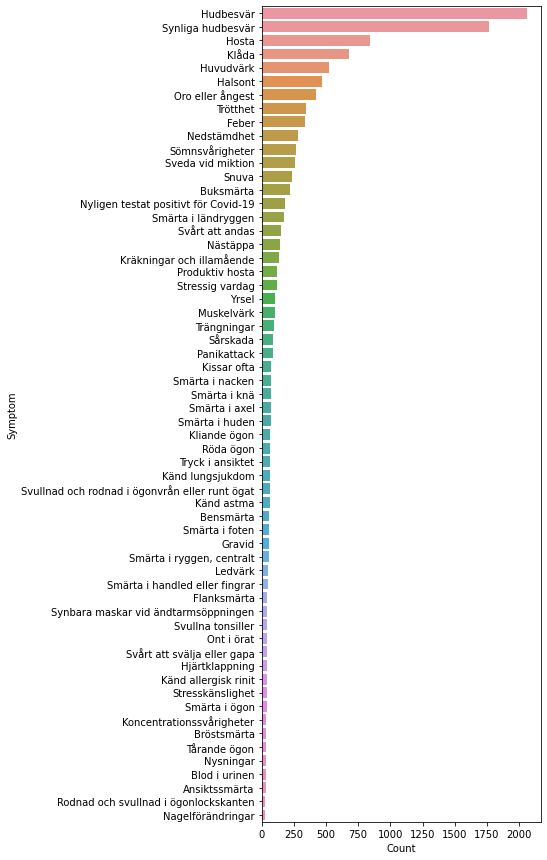

In [4]:
# plot the distribution of labels
all_syms = sum(sym_names,[])
all_syms = nltk.FreqDist(all_syms)

all_syms_df = pd.DataFrame({'Symptom': list(all_syms.keys()),
                            'Count': list(all_syms.values())
                           })

g = all_syms_df.nlargest(columns='Count', n=60)
plt.figure(figsize=(5,15))
ax = sns.barplot(data=g, x='Count', y='Symptom')

2:	 28.97 %
1:	 30.10 %
3:	 12.12 %
0:	 21.85 %
4:	 4.29 %
6:	 0.61 %
5:	 1.54 %
7:	 0.36 %
10:	 0.01 %
8:	 0.10 %
11:	 0.02 %
9:	 0.04 %


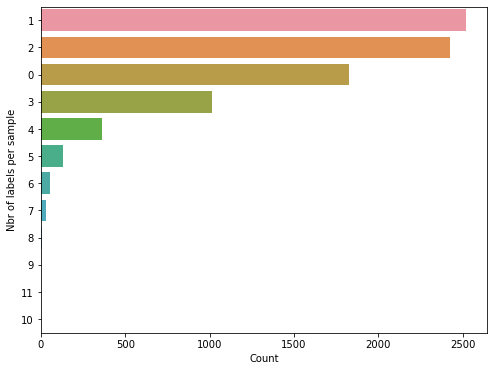

In [5]:
# plot the distribution of number of labels per sample
count_list = []

for sym_list in df['labels']:
    count_list.append(f'{len(sym_list)}')
    
count_dict = nltk.FreqDist(count_list)
count_dict_df = pd.DataFrame({'Nbr of labels per sample': list(count_dict.keys()),
                              'Count': list(count_dict.values())
                             })

# print percentages
count_dict_df = count_dict_df.sort_values(by=['Count'])
tot_samples = sum(count_dict_df['Count'].tolist())
for i in range(len(count_dict_df)):
    print(f'{count_dict_df["Nbr of labels per sample"][i]}:\t {count_dict_df["Count"][i] / tot_samples * 100:.2f} %')

g = count_dict_df.nlargest(columns='Count', n=60)

plt.figure(figsize=(8,6))
ax = sns.barplot(data=g, x='Count', y='Nbr of labels per sample')

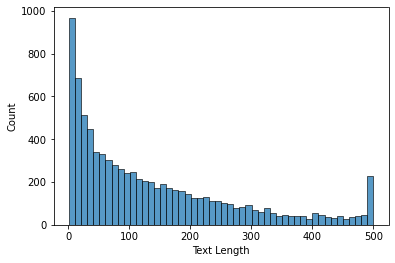

In [6]:
# plot the distribution of text lengths
length_list = []

for text in df['text']:
    length_list.append(len(text))

length_list_df = pd.DataFrame({'Text Length': length_list})

ax = sns.histplot(data=length_list_df, x='Text Length', bins=50)

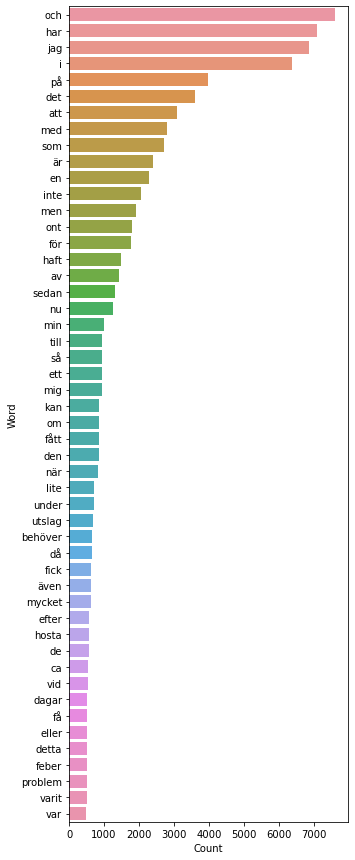

In [7]:
# plot the distribution of words
def clean_text(text):
    # turn text to lowercase
    text = text.lower()
    
    # remove all characters that are not letters or whitespace
    text = re.sub(r'[^\p{L} ]', '', text)
    
    return text

words = df['text'].tolist()
all_words = [clean_text(x).split() for x in words]
all_words = sum(all_words,[])
all_words = nltk.FreqDist(all_words)

all_words_df = pd.DataFrame({'Word': list(all_words.keys()),
                            'Count': list(all_words.values())
                           })

g = all_words_df.nlargest(columns='Count', n=50)
plt.figure(figsize=(5,15))
ax = sns.barplot(data=g, x='Count', y='Word')

In [9]:
# further explore the distribution of labels
labels = df['labels'].tolist()

multilab_bin = MultiLabelBinarizer()
y = multilab_bin.fit_transform(labels)

label_counts = np.sum(y, axis=0)
label_counts = np.flip(np.sort(label_counts))
print('Number of occurrences per label:')
print(label_counts)

n = 20
accum_per = np.sum([label_counts[:n]]) / np.sum(label_counts) * 100
print(f'The {n} most common labels make up {accum_per:.2f} % of all label occurrences')

m = 5
below_m = label_counts[label_counts < m]
print(f'{len(below_m)}/{len(label_counts)} labels have less than {m} occurrences')

Number of occurrences per label:
[2062 1761  842  678  527  468  420  341  339  284  269  261  237  221
  179  173  150  143  135  120  119  108  104   98   86   85   77   77
   75   74   71   68   68   66   63   63   62   61   57   55   54   53
   49   45   44   44   44   44   44   41   40   39   38   37   36   34
   32   31   29   29   27   25   25   24   23   22   21   21   20   20
   20   20   19   19   19   18   18   17   16   16   16   16   16   16
   16   14   14   14   14   14   14   14   14   14   13   13   13   13
   13   12   12   12   12   12   11   11   11   11   10   10   10   10
   10   10    9    9    8    8    8    8    7    7    7    7    6    6
    6    6    6    6    6    6    5    5    5    5    5    5    5    5
    5    5    4    4    4    4    4    4    4    4    4    4    3    3
    3    3    3    3    3    3    3    3    3    3    3    3    2    2
    2    2    2    2    2    2    2    2    2    2    2    2    2    2
    2    2    2    2    2    1    1    1    

In [ ]:
# find duplicates in dataset
dup_count = 0

# get dict with symptom to counts
sym_counts = {}
for i in range(len(all_syms_df)):
    sym_counts[all_syms_df['Symptom'][i]] = all_syms_df['Count'][i]

check_set = set()

for i in range(len(df)):
    if df['labels'][i] == []:
        continue
    
    if (df['text'][i], tuple(df['labels'][i])) in check_set: 
        if df['labels'][i] != [] and len(df['text'][i]) > 50:
            print(f'{df["text"][i]}\n{df["labels"][i]}\n({check_dict[df["text"][i]][0]},{i})')
            for j in range(len(df['labels'][i])):
                print(f"{df['labels'][i][j]}: {sym_counts[df['labels'][i][j]]}")
            print()
            dup_count += 1
    else:
        check_set.add((df['text'][i], tuple(df['labels'][i])))
        
print(dup_count)

In [ ]:
inds = (7702,7703)

print(f"{df['text'][inds[0]]}\n{df['labels'][inds[0]]}\n")
print(f"{df['text'][inds[1]]}\n{df['labels'][inds[1]]}\n")
print()

print(f'Total number of samples in df: {len(df)}')